In [21]:
import numpy as np
import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm
import math
from torch.utils.tensorboard import SummaryWriter

import pickle
import csv
import sys

sys.path.append('src/')

# Own libraries
import utils
import trainer_WGAN as trainer
import model_WGAN
import WGAN
import models

torch.manual_seed(42)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#writer = SummaryWriter('runs/SSPA_WGAN_bigger_model')

# Encoding parameters

n = 8 #7
M = 64 #16
k = math.log2(M)
TRAINING_SNR = 9
rate = k/n
noise_std = utils.EbNo_to_noise(TRAINING_SNR, rate)
save_every = 1000


#GAN parameters
g_input_size = 2*n      # Random noise dimension coming into generator, per output vector
g_hidden_size = 256 # Generator complexity
g_output_size = n     # Size of generated output vector

d_input_size = 2*n    # Minibatch size - cardinality of distributions
d_hidden_size = 256    # Discriminator complexity
d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification

batch_size = 5000
num_epochs = 20000

G = WGAN.Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = WGAN.Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)
G = G.to(device)
D = D.to(device)

writer_G = SummaryWriter('runs/SSPA_WGAN_G')
writer_D = SummaryWriter('runs/SSPA_WGAN_D')
#example_data_g = torch.rand(size=(1,n)).to(device)
#writer_G.add_graph(G, example_data_g)
#writer_D.add_graph(D, (G(example_data_g), example_data_g))

d_lr = 1e-4
g_lr = 1e-4

channel_sspa = model_WGAN.Channel_SSPA_only(noise_std)

In [6]:
total_params_g = sum(p.numel() for p in G.parameters())
print('# of parameters (WGAN model Generator): ' + str(total_params_g))
total_params_d = sum(p.numel() for p in D.parameters())
print('# of parameters (WGAN model Critic): ' + str(total_params_d))

# of parameters (WGAN model Generator): 72200
# of parameters (WGAN model Critic): 70401


# Training GAN


In [22]:
milestone=100

G.load_state_dict(torch.load(f'state_dict_WGAN/G_SSPA-{milestone}.pt'))#, map_location="cpu"))
G.eval()

D.load_state_dict(torch.load(f'state_dict_WGAN/D_SSPA-{milestone}.pt'))#, map_location="cpu"))
D.eval()


Discriminator(
  (map1): Linear(in_features=16, out_features=256, bias=True)
  (map2): Linear(in_features=256, out_features=256, bias=True)
  (map3): Linear(in_features=256, out_features=1, bias=True)
  (f): ReLU()
)

In [8]:
num_epochs = 50000
g_lr=1e-5; d_lr=1e-5
epochs = tqdm(range(num_epochs), ascii=True)

for epoch in epochs:
    kl, g_loss = WGAN.train_WGAN(G, D, batch_size, n, channel_sspa, d_lr, g_lr, is_GP=False)
    example_data_g = torch.rand(size=(1,n)).to(device)
    writer_G.add_scalar('Loss/G train', g_loss, epoch)
    writer_G.add_scalar('KL Div/G train', kl, epoch)
    if (epoch+1) % 100 == 0:
        epochs.set_description(f"Epoch {epoch+1}: KL Div {kl:.3e} G loss {-g_loss:.3e}")
    if (epoch+1) % save_every == 0:
        torch.save(G.state_dict(), f'state_dict_WGAN/G_SSPA-{(epoch+1)//save_every}.pt')
        torch.save(D.state_dict(), f'state_dict_WGAN/D_SSPA-{(epoch+1)//save_every}.pt')


Epoch 50000: KL Div 1.643e-03 G loss 1.539e-02: 100%|#| 50000/50000 [17:32<00:00


Epoch 1:  


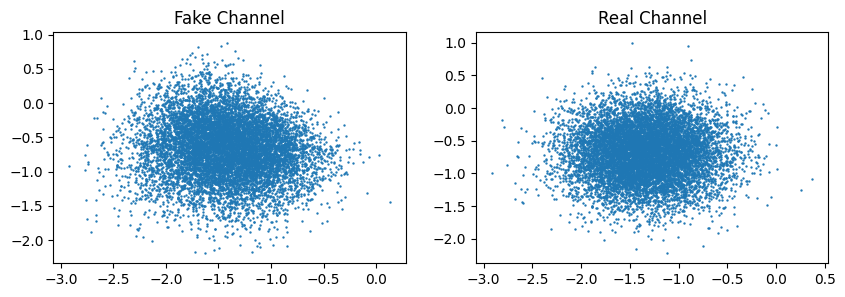

In [24]:
WGAN.plot_GAN_m(G, 10000,M, n, channel_sspa, 1 , device)

# Training GAN Encoder

In [28]:
encoder_GAN = models.Encoder_1h( M, n, n/2)
decoder_GAN = models.Decoder_1h( M, n)

encoder_GAN.load_state_dict(torch.load(f'state_dict_WGAN/enc_GAN_SSPA.pt'))#, map_location="cpu"))
encoder_GAN.eval()
encoder_GAN = encoder_GAN.to(device)

decoder_GAN.load_state_dict(torch.load(f'state_dict_WGAN/dec_GAN_SSPA.pt'))#, map_location="cpu"))
decoder_GAN.eval()
decoder_GAN = decoder_GAN.to(device)


In [29]:
dataset = np.random.randint(0, M, size=10000000) # size = 10000000

In [30]:
encoder_GAN = models.Encoder_1h( M, n, n/2)
decoder_GAN = models.Decoder_1h( M, n)
channel = model_WGAN.Channel_GAN(encoder_GAN, decoder_GAN, G).to(device)
tconf = trainer.TrainerConfig(max_epochs=40, noise_std = noise_std, batch_size=1000, M=M, rate=rate, learning_rate=1e-3, TRAINING_EbN0=TRAINING_SNR) # epoch = 10, batch_size = 1000
weights = filter(lambda p: p.requires_grad, list(encoder_GAN.parameters())+list(decoder_GAN.parameters()))
t_gan = trainer.Trainer(channel, dataset, tconf, one_hot=True)

t_gan.train(weights=weights, GAN=True, global_epoch=0)

epoch 1: loss 2.66e-02 SER 3.91e-03: 100%|#| 10000/10000 [00:42<00:00, 236.68it/
epoch 2: loss 9.70e-04 SER 3.17e-04: 100%|#| 10000/10000 [00:43<00:00, 232.06it/
epoch 3: loss 8.29e-04 SER 2.64e-04: 100%|#| 10000/10000 [00:42<00:00, 233.32it/
epoch 4: loss 7.69e-04 SER 2.46e-04: 100%|#| 10000/10000 [00:47<00:00, 210.80it/
epoch 5: loss 7.14e-04 SER 2.29e-04: 100%|#| 10000/10000 [00:48<00:00, 207.76it/
epoch 6: loss 6.52e-04 SER 2.05e-04: 100%|#| 10000/10000 [00:46<00:00, 214.16it/
epoch 7: loss 6.35e-04 SER 1.99e-04: 100%|#| 10000/10000 [00:48<00:00, 204.54it/
epoch 8: loss 6.12e-04 SER 1.89e-04: 100%|#| 10000/10000 [00:49<00:00, 200.58it/
epoch 9: loss 5.65e-04 SER 1.80e-04: 100%|#| 10000/10000 [00:46<00:00, 216.46it/
epoch 10: loss 5.60e-04 SER 1.74e-04: 100%|#| 10000/10000 [00:48<00:00, 206.82it
epoch 11: loss 5.70e-04 SER 1.81e-04: 100%|#| 10000/10000 [00:47<00:00, 209.26it
epoch 12: loss 5.42e-04 SER 1.71e-04: 100%|#| 10000/10000 [00:47<00:00, 208.89it
epoch 13: loss 5.23e-04 SER 

In [32]:
#model_1 = model_WGAN.Channel_GAN(encoder_GAN, decoder_GAN, G).to(device)
tconf = trainer.TrainerConfig(max_epochs=20, noise_std = noise_std, batch_size=1000,
                              M=M, rate=rate, learning_rate = 1e-4, TRAINING_EbN0=TRAINING_SNR) # epoch = 10, batch_size = 1000
weights = filter(lambda p: p.requires_grad, list(encoder_GAN.parameters())+list(decoder_GAN.parameters()))
t_gan = trainer.Trainer_(encoder_GAN, decoder_GAN, G, dataset, tconf, one_hot=True)#, writer=writer)
t_gan.train(weights=weights, GAN=True,global_epoch=0)
    

epoch 1: loss 1.74e-04 SER 5.26e-05: 100%|#| 10000/10000 [00:39<00:00, 251.92it/
SNR 9  iter 9900: SER 1.028e-03: 100%|###| 10000/10000 [00:16<00:00, 590.19it/s]


epoch 1: validation SER 1.03e-03


epoch 2: loss 1.11e-04 SER 3.40e-05: 100%|#| 10000/10000 [00:39<00:00, 253.28it/
SNR 9  iter 9900: SER 1.056e-03: 100%|###| 10000/10000 [00:16<00:00, 592.21it/s]


epoch 2: validation SER 1.06e-03


epoch 3: loss 1.22e-04 SER 3.79e-05: 100%|#| 10000/10000 [00:40<00:00, 246.49it/
SNR 9  iter 9900: SER 1.066e-03: 100%|###| 10000/10000 [00:16<00:00, 593.91it/s]


epoch 3: validation SER 1.07e-03


epoch 4: loss 1.09e-04 SER 3.52e-05: 100%|#| 10000/10000 [00:40<00:00, 247.54it/
SNR 9  iter 9900: SER 1.049e-03: 100%|###| 10000/10000 [00:16<00:00, 594.08it/s]


epoch 4: validation SER 1.05e-03


epoch 5: loss 1.13e-04 SER 3.51e-05: 100%|#| 10000/10000 [00:41<00:00, 243.53it/
SNR 9  iter 9900: SER 1.096e-03: 100%|###| 10000/10000 [00:16<00:00, 589.92it/s]


epoch 5: validation SER 1.10e-03


epoch 6: loss 1.17e-04 SER 3.66e-05: 100%|#| 10000/10000 [00:40<00:00, 248.32it/
SNR 9  iter 9900: SER 1.068e-03: 100%|###| 10000/10000 [00:17<00:00, 588.20it/s]


epoch 6: validation SER 1.07e-03


epoch 7: loss 1.15e-04 SER 3.76e-05: 100%|#| 10000/10000 [00:40<00:00, 249.89it/
SNR 9  iter 9900: SER 1.146e-03: 100%|###| 10000/10000 [00:16<00:00, 592.38it/s]


epoch 7: validation SER 1.14e-03


epoch 8: loss 1.14e-04 SER 3.37e-05: 100%|#| 10000/10000 [00:40<00:00, 245.19it/
SNR 9  iter 9900: SER 1.107e-03: 100%|###| 10000/10000 [00:16<00:00, 593.44it/s]


epoch 8: validation SER 1.11e-03


epoch 9: loss 1.26e-04 SER 3.86e-05: 100%|#| 10000/10000 [00:40<00:00, 246.64it/
SNR 9  iter 9900: SER 1.052e-03: 100%|###| 10000/10000 [00:16<00:00, 596.85it/s]


epoch 9: validation SER 1.05e-03


epoch 10: loss 1.16e-04 SER 3.52e-05: 100%|#| 10000/10000 [00:40<00:00, 247.01it
SNR 9  iter 9900: SER 1.114e-03: 100%|###| 10000/10000 [00:16<00:00, 593.07it/s]


epoch 10: validation SER 1.11e-03


epoch 11: loss 1.20e-04 SER 3.55e-05: 100%|#| 10000/10000 [00:40<00:00, 248.84it
SNR 9  iter 9900: SER 1.093e-03: 100%|###| 10000/10000 [00:17<00:00, 588.21it/s]


epoch 11: validation SER 1.09e-03


epoch 12: loss 1.17e-04 SER 3.57e-05: 100%|#| 10000/10000 [00:40<00:00, 246.18it
SNR 9  iter 9900: SER 1.079e-03: 100%|###| 10000/10000 [00:16<00:00, 595.14it/s]


epoch 12: validation SER 1.08e-03


epoch 13: loss 1.20e-04 SER 3.81e-05: 100%|#| 10000/10000 [00:40<00:00, 248.77it
SNR 9  iter 9900: SER 1.105e-03: 100%|###| 10000/10000 [00:16<00:00, 592.45it/s]


epoch 13: validation SER 1.11e-03


epoch 14: loss 1.13e-04 SER 3.55e-05: 100%|#| 10000/10000 [00:40<00:00, 246.52it
SNR 9  iter 9900: SER 1.116e-03: 100%|###| 10000/10000 [00:16<00:00, 594.92it/s]


epoch 14: validation SER 1.12e-03


epoch 15: loss 1.26e-04 SER 4.00e-05: 100%|#| 10000/10000 [00:40<00:00, 247.18it
SNR 9  iter 9900: SER 1.162e-03: 100%|###| 10000/10000 [00:16<00:00, 590.77it/s]


epoch 15: validation SER 1.16e-03


epoch 16: loss 1.19e-04 SER 3.50e-05: 100%|#| 10000/10000 [00:40<00:00, 247.48it
SNR 9  iter 9900: SER 1.108e-03: 100%|###| 10000/10000 [00:16<00:00, 594.94it/s]


epoch 16: validation SER 1.11e-03


epoch 17: loss 1.28e-04 SER 4.00e-05: 100%|#| 10000/10000 [00:40<00:00, 249.43it
SNR 9  iter 9900: SER 1.096e-03: 100%|###| 10000/10000 [00:16<00:00, 594.94it/s]


epoch 17: validation SER 1.10e-03


epoch 18: loss 1.28e-04 SER 4.03e-05: 100%|#| 10000/10000 [00:40<00:00, 247.07it
SNR 9  iter 9900: SER 1.115e-03: 100%|###| 10000/10000 [00:16<00:00, 594.77it/s]


epoch 18: validation SER 1.12e-03


epoch 19: loss 1.31e-04 SER 4.23e-05: 100%|#| 10000/10000 [00:40<00:00, 249.27it
SNR 9  iter 9900: SER 1.081e-03: 100%|###| 10000/10000 [00:16<00:00, 593.95it/s]


epoch 19: validation SER 1.08e-03


epoch 20: loss 1.31e-04 SER 4.10e-05: 100%|#| 10000/10000 [00:40<00:00, 247.56it
SNR 9  iter 9900: SER 1.070e-03: 100%|###| 10000/10000 [00:16<00:00, 595.31it/s]

epoch 20: validation SER 1.07e-03


In [40]:
torch.save(encoder_GAN.state_dict(), 'state_dict_WGAN/enc_GAN_SSPA.pt')
torch.save(decoder_GAN.state_dict(), 'state_dict_WGAN/dec_GAN_SSPA.pt')

In [27]:
#torch.save(channel.state_dict(), path)

In [ ]:
#channel.load_state_dict(torch.load(path, map_location=device))

# Training AE Encoder

In [38]:
encoder_AE = models.Encoder_1h(M, n, n/2)
decoder_AE = models.Decoder_1h( M, n)
model_2 = model_WGAN.Channel_GAN_SSPA(encoder_AE, decoder_AE, channel_sspa).to(device)
#model_2 = model_WGAN.Channel(encoder_AE, decoder_AE).to(device)

tconf = trainer.TrainerConfig(max_epochs=10, noise_std = noise_std, batch_size=1000, M=M, rate=rate,
                              TRAINING_EbN0=TRAINING_SNR)
weights = filter(lambda p: p.requires_grad, model_2.parameters())

t_ae = trainer.Trainer(model_2, dataset, tconf, one_hot=True)
t_ae.train(weights=weights, GAN=False)

epoch 1: loss 3.17e-02 SER 5.56e-03: 100%|#| 10000/10000 [00:31<00:00, 317.62it/
epoch 2: loss 3.20e-03 SER 1.06e-03: 100%|#| 10000/10000 [00:33<00:00, 301.91it/
epoch 3: loss 2.89e-03 SER 9.62e-04: 100%|#| 10000/10000 [00:34<00:00, 293.44it/
epoch 4: loss 2.75e-03 SER 9.24e-04: 100%|#| 10000/10000 [00:33<00:00, 295.99it/
epoch 5: loss 2.65e-03 SER 8.84e-04: 100%|#| 10000/10000 [00:36<00:00, 276.59it/
epoch 6: loss 2.50e-03 SER 8.45e-04: 100%|#| 10000/10000 [00:38<00:00, 262.07it/
epoch 7: loss 2.47e-03 SER 8.20e-04: 100%|#| 10000/10000 [00:37<00:00, 263.96it/
epoch 8: loss 2.39e-03 SER 7.99e-04: 100%|#| 10000/10000 [00:37<00:00, 267.42it/
epoch 9: loss 2.30e-03 SER 7.64e-04: 100%|#| 10000/10000 [00:40<00:00, 246.08it/
epoch 10: loss 2.31e-03 SER 7.70e-04: 100%|#| 10000/10000 [00:40<00:00, 249.03it


# Testing AE & GAN Encoder under real channel

In [5]:
dataset = np.random.randint(0,M, size=10000000)

In [6]:
bler_testGAN =[]
#ebno_range = [4,5,6,7,8]
ebno_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model_testGAN = model_WGAN.Channel_SSPA(encoder_GAN, decoder_GAN).to(device)
tconf = trainer.TrainerConfig(max_epochs=5, noise_std = noise_std, batch_size=1000, M=M, rate=rate)

t_testGAN = trainer.Trainer(model_testGAN, dataset, tconf, one_hot=True)


bler_testGAN = t_testGAN.test(snr_range=ebno_range, one_hot=True, erasure_bound=0.7)
print(bler_testGAN)

SNR 11  iter 9900: SER 3.989e-05: 100%|##| 10000/10000 [00:11<00:00, 898.94it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 11  iter 9900: SER 4.323e-05: 100%|##| 10000/10000 [00:11<00:00, 902.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 11  iter 9900: SER 3.888e-05: 100%|##| 10000/10000 [00:11<00:00, 894.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 11  iter 9900: SER 4.000e-05: 100%|##| 10000/10000 [00:11<00:00, 894.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 11  iter 9900: SER 4.030e-05: 100%|##| 10000/10000 [00:11<00:00, 891.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 11  iter 9900: SER 4.292e-05: 100%|##| 10000/10000 [00:11<00:00, 897.94it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 11  iter 9900: SER 4.040e-05: 100%|##| 10000/10000 [00:11<00:00, 867.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 11  iter 9900: SER 4.090e-05: 100%|##| 10000/10000 [00:11<00:00, 886.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 11  iter 9900: SER 4.202e-05: 100%|##| 10000/10000 [00:11<00:00, 904.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 11  iter 9900: SER 4.363e-05: 100%|##| 10000/10000 [00:11<00:00, 906.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 11  iter 9900: SER 4.161e-05: 100%|##| 10000/10000 [00:11<00:00, 908.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 11  iter 9900: SER 4.030e-05: 100%|##| 10000/10000 [00:11<00:00, 908.54it/s]

[0.44643542127907276, 0.34643401630818843, 0.24821411151885986, 0.16039860734567046, 0.09100400411114097, 0.04446110201030969, 0.017975500948168337, 0.0058623002505162735, 0.0014787000569049268, 0.00029470001352601685, 4.116154041571113e-05]


In [49]:
bler_testAE =[]
ebno_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model_testAE = model_WGAN.Channel(encoder_AE, decoder_AE).to(device)
tconf = trainer.TrainerConfig(max_epochs=5, noise_std = noise_std, batch_size=1000, M=M, rate=rate)

t_testAE = trainer.Trainer(model_testAE, dataset, tconf, one_hot=True)


bler_testAE = t_testAE.test(snr_range=ebno_range, one_hot=True, erasure_bound=0.7)

SNR 11  iter 9900: SER 8.565e-05: 100%|##| 10000/10000 [00:17<00:00, 568.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 11  iter 9900: SER 8.777e-05: 100%|##| 10000/10000 [00:17<00:00, 565.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 11  iter 9900: SER 8.676e-05: 100%|##| 10000/10000 [00:17<00:00, 569.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 11  iter 9900: SER 8.575e-05: 100%|##| 10000/10000 [00:17<00:00, 569.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 11  iter 9900: SER 9.272e-05: 100%|##| 10000/10000 [00:17<00:00, 569.20it/s]


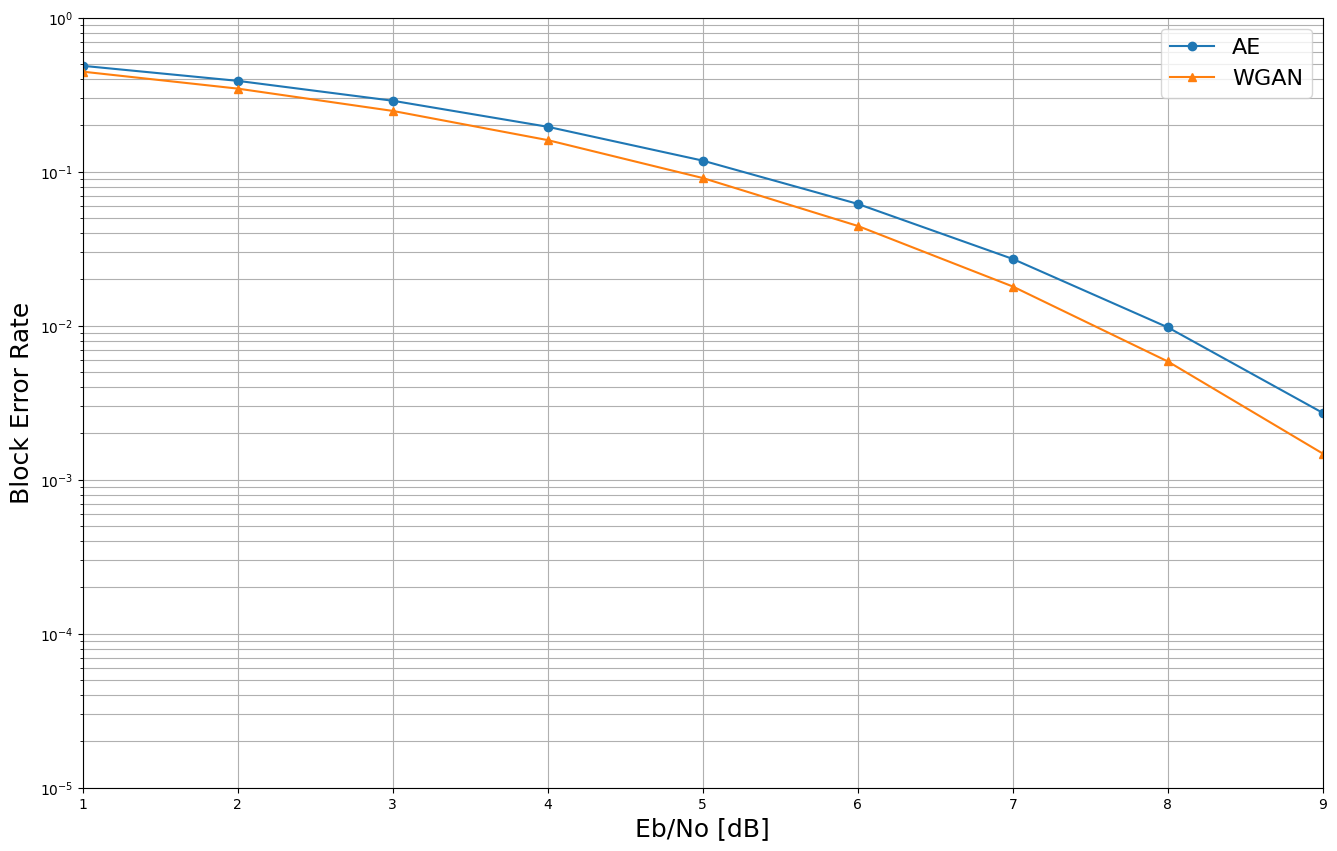

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 10))
# Plot Autoencoder
plt.semilogy(ebno_range, bler_testAE, 'o-')
#plt.semilogy(bber_data[0], bber_data[2], 'o-')
#plt.semilogy(bber_data[0], vec, 'o-')

plt.semilogy(ebno_range, bler_testGAN, '^-')


# Plot approx 16 QAM
#ebnodbs = np.linspace(5,14,10)
#a, _ = utils.MQAM_rayleigh_approx(16,ebnodbs)
#plt.plot(ebnodbs, a, '^-');

#b = [utils.rayleigh_error(t) for t in ebnodbs]
#plt.plot(ebnodbs, b, '^-');

#ebnodbs = np.linspace(0,11,22)
#uncoded_16QAM_Rayleigh_SER = [0.5501, 0.5040, 0.4564, 0.4082, 0.3606, 0.3147, 0.2713, 0.2313, 0.1951, 0.1631, 0.1352, 0.1112, 0.091, 0.07396, 0.05989, 0.04832, 0.03886, 0.03119, 0.02497, 0.01996, 0.01594, 0.01271]
#c = [(1-(1-t)**4) for t in uncoded_16QAM_Rayleigh_SER]
#plt.plot(ebnodbs, c, '^-');

plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(1, 9)
plt.ylabel("Block Error Rate", fontsize=18, rotation=90)
plt.xlabel("Eb/No [dB]", fontsize=18)
plt.legend(['AE', 'WGAN'], prop={'size': 16}, loc='upper right');
plt.grid(True, which="both")
#plt.savefig('ae-ray-testing.pdf')